In [461]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy.random as random
import time
import pdb
import copy
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 16

In [ ]:
# For competition, You should be able to read and write CSV files. For example, in Python, you may use numpy.loadtxt() and numpy.savetxt(). You may also require analogs of functions such as numpy.reshape() and matplotlib.pyplot.imshow().

#### Define functions

In [518]:
def gen_data(num_samples, dim, sigma, scaling=1, seed=0, func="no_sparse_constraint", sparsity=None):
    random.seed(seed)
    if func == "no_sparse_constraint":
        theta_gt = random.randint(0, 2, size=(dim,))
    elif func == "sparse_constraint":
        assert sparsity is not None
        theta_gt = np.zeros(dim)
        indices_of_ones = random.choice(dim, sparsity, replace=False)
        theta_gt[indices_of_ones] = 1
    else:
        raise NotImplementedError
    x = random.randn(num_samples,dim) * scaling
    noise = random.randn(num_samples) * sigma
    y = x @ theta_gt + noise
    return x, y, theta_gt

def state_init(dim, sparsity=None, func="no_sparse_constraint"):
    if func == "no_sparse_constraint":
        init_theta = random.randint(0, 2, size=(dim,))
        return init_theta
    elif func == "sparse_constraint":
        assert sparsity is not None
        init_theta = np.zeros(dim)
        indices_of_ones = random.choice(dim, sparsity, replace=False)
        init_theta[indices_of_ones] = 1
        return init_theta
    else:
        raise NotImplementedError

def trans(x, curr_pred, theta, func="1_bit_random_flip", sparsity=None, indices_one=None, indices_zero=None):
    # new_theta = copy.deepcopy(theta)
    new_theta = np.copy(theta)
    others_to_return = None
    if func == "1_bit_random_flip":  # question 1
        ind = random.randint(0, len(theta))
        new_theta[ind] = 1 - theta[ind]
        diff = x[:, ind] * (1 - 2 * theta[ind])
    elif func == "2_bit_random_flip_for_sparsity":  # question 2 & 3
        assert indices_one is not None and indices_zero is not None
        assert sparsity is not None
        # pdb.set_trace()
        loc_one = random.randint(0, len(indices_one))
        loc_zero = random.randint(0, len(indices_zero))
        indice_one = indices_one[loc_one]
        indice_zero = indices_zero[loc_zero]
        # if new_theta[indice_one]!=1 or new_theta[indice_zero]!=0:
        #     print(new_theta[indice_one], new_theta[indice_zero])
        #     pdb.set_trace()
        new_theta[indice_one] = 0
        new_theta[indice_zero] = 1
        # delete old and add new indices

        indices_one = np.delete(indices_one, loc_one)
        indices_zero= np.delete(indices_zero, loc_zero)

        indices_one = np.append(indices_one, indice_zero)
        indices_zero = np.append(indices_zero, indice_one)

        # new_theta = np.zeros(len(theta))
        # new_theta[indices_one] = 1
        diff = x[:, indice_zero] - x[:, indice_one]
        others_to_return = (indices_one, indices_zero)
    elif func == "2_bit_random_swap_for_sparsity":  # question 2 & 3, mentioned in the project description
        assert sparsity is not None
        indices = random.choice(len(theta), 2, replace=False)
        if theta[indices[0]] == theta[indices[1]]:
            diff = 0
        else:
            new_theta[indices[0]], new_theta[indices[1]] = new_theta[indices[1]], new_theta[indices[0]]
            diff = x[:, indices[0]] * (1 - 2 * theta[indices[0]]) + x[:, indices[1]] * (1 - 2 * theta[indices[1]])
    elif func == "multi_bit_random_flip_for_sparsity":  # question 2 & 3
        assert indices_one is not None and indices_zero is not None
        assert sparsity is not None
        num = random.randint(1, 4)
        loc_one = random.choice(len(indices_one), num, replace=False)
        loc_zero = random.choice(len(indices_zero), num, replace=False)
        indice_one = indices_one[loc_one]
        indice_zero = indices_zero[loc_zero]
        new_theta[indice_one] = 0
        new_theta[indice_zero] = 1
        # delete old and add new indices
        indices_one = np.delete(indices_one, loc_one)
        indices_zero= np.delete(indices_zero, loc_zero)
        indices_one = np.append(indices_one, indice_zero)
        indices_zero = np.append(indices_zero, indice_one)
        diff = x[:, indice_zero].sum(axis=1) - x[:, indice_one].sum(axis=1)
        others_to_return = (indices_one, indices_zero)
    elif func == "2_bit_random_swap_for_sparsity_improved":  # question 2 & 3, too slow
        assert sparsity is not None
        indices = random.choice(len(theta), 2, replace=False)
        while theta[indices[0]] == theta[indices[1]]:
            indices = random.choice(len(theta), 2, replace=False)
        new_theta[indices[0]], new_theta[indices[1]] = new_theta[indices[1]], new_theta[indices[0]]
        diff = x[:, indices[0]] * (1 - 2 * theta[indices[0]]) + x[:, indices[1]] * (1 - 2 * theta[indices[1]])
    elif func == "random_walk_for_sparsity":  # question 2 & 3, not working
        assert sparsity is not None
        new_theta = np.zeros(len(theta))
        indices_of_ones = random.choice(len(theta), sparsity, replace=False)
        new_theta[indices_of_ones] = 1
        diff = x[:, indices_of_ones].sum(axis=1) - curr_pred
    else:
        raise NotImplementedError

    return new_theta, curr_pred + diff, others_to_return

def obj(y, pred, func="2-norm", delta=0.01):
    if func == "2-norm":
        return np.linalg.norm(y - pred)
    elif func == "1-norm":
        return np.linalg.norm(y - pred, ord=1)
    elif func == "2-norm-sign":
        return np.linalg.norm(y - np.sign(pred))
    elif func == "test":  # to check if the obj is the bottleneck. The answer was yes.
        return 1
    elif func == "logistic_exponential":
        y = (y + 1) / 2
        pred = (pred + 1) / 2
        return np.log(1 + np.exp(-y * pred)).mean()
    elif func == "zero_one_loss":
        return (y * pred < 0).mean()
    elif func == "hinge_loss":
        return np.maximum(0, 1 - y * pred).mean()
    elif func == "bce_loss":
        y = (y + 1) / 2
        pred = (pred + 1) / 2
        return - (y * np.log(pred + delta) + (1 - y) * np.log(1 - pred + delta)).mean()
    else:
        raise NotImplementedError

def accept(beta, diff):
    if beta * diff <= 0:
        return 1
    else:
        return np.exp(-beta * diff)

def opt_beta_estimator(x, y, obj, obj_func, eps, dim, num_trials=10000):
    vals = []
    for _ in range(num_trials):
        theta = np.bool_(random.randint(0, 2, size=(dim,)))
        pred = x[:, theta].sum(axis=1)
        vals.append(obj(y, pred, obj_func))
    sorted_vals = np.sort(vals)
    f0 = sorted_vals[0]
    N0 = ((sorted_vals - f0) == 0).sum()
    f1_index = np.where((sorted_vals - f0) > 0)[0][0]
    f1 = sorted_vals[f1_index]
    N1 = ((sorted_vals - f1) == 0).sum()
    estimated_beta = np.log(N1 / (N0 * eps)) / (f1 - f0)
    return estimated_beta

def gen_beta_seq(x, y, obj, eps, dim, num_iters=1000, func="constant", obj_func="2-norm", constant=1):
    if func == "constant":
        betas = np.ones((num_iters,)) * constant
    elif func == "constant_opt":
        opt_beta = opt_beta_estimator(x, y, obj, obj_func, eps, dim)
        print("estimated beta: ", opt_beta)
        betas = np.ones((num_iters,)) * opt_beta
    elif func == "simulated_annealing":
        betas = np.linspace(0.5, 7.5, num_iters)
        # betas = np.geomspace(0.1, 5, num_iters)
    else:
        raise NotImplementedError
    return betas

def eval(theta_gt, thetas, coef, warmup_iters, mode='normal'):
    if warmup_iters < 0:
        theta = thetas[-1]
    else:
        if mode == 'normal':
            theta = np.mean(thetas[warmup_iters:], axis=0)
        elif mode == 'hard':
            theta = np.mean(thetas[warmup_iters:], axis=0)
            theta = np.round(theta)
        else:
            raise NotImplementedError
    return np.linalg.norm(theta_gt - theta) * coef

def run_MH(x, y, num_iters, betas, trans_func, obj_func, curr_theta, sparsity=None):
    thetas, vals = [], []
    curr_pred = x @ curr_theta
    curr_val = obj(y, curr_pred, obj_func)

    if trans_func == "2_bit_random_flip_for_sparsity" or trans_func == "multi_bit_random_flip_for_sparsity":  # avoid np.where every time
        indices_one = np.where(curr_theta==1)[0]
        indices_zero = np.where(curr_theta==0)[0]
    else:
        indices_one = None
        indices_zero = None

    for i in range(num_iters):
        next_theta, next_pred, others = trans(x, curr_pred, curr_theta, trans_func, sparsity=sparsity, indices_one=indices_one, indices_zero=indices_zero)

        # if len(np.where(next_theta==1)[0]) != 20:
        #     pdb.set_trace()
        # print(len(np.where(next_theta==1)[0]))
        next_val = obj(y, next_pred, obj_func)
        acceptance = accept(betas[i], next_val - curr_val)
        if random.random() <= acceptance:
            curr_theta = next_theta
            curr_pred = next_pred
            curr_val = next_val
            if trans_func == "2_bit_random_flip_for_sparsity" or trans_func == "multi_bit_random_flip_for_sparsity":  # avoid np.where every time
                indices_one, indices_zero = others
        thetas.append(curr_theta)
        vals.append(curr_val)



    return thetas, vals

def plot_error(num_samples_list, error_list, coef='d'):
    # plot the means squraed error as a function of the number of samples
    plt.plot(num_samples_list, error_list, marker='o')
    plt.grid()
    if coef=='d':
        plt.title(r"Mean squared error ($\frac{2}{d}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")
    else:
        plt.title(r"Mean squared error ($\frac{1}{2s}\mathbb{E} \Vert \hat{\theta}-\theta \Vert ^2$) as a function of the number of samples")
    plt.xlabel("number of samples")
    plt.ylabel("mean squared error")

def plot_error_wrt_beta(num_samples_list, error_list, beta_list, coef='d'):
    # plot the means squraed error as a function of the number of samples
    marker_list = ['o', 'v', 's', 'x', '*', '>', '<']
    for i, (b, e) in enumerate(error_list.items()):
        plt.plot(num_samples_list, e, marker=marker_list[i], label=r'$\beta$='+str(b))
    plt.grid()
    plt.legend()
    plt.xlabel("number of samples")
    plt.ylabel("mean squared error")

def plot_obj(num_samples_list, all_vals):
    # plot the objective as a function of the number of iterations
    for i, vals in enumerate(all_vals):
        plt.plot(range(len(vals)), vals)
    plt.grid()
    plt.legend(num_samples_list)
    plt.title(r"Objective as a function of the number of iterations")  # remember to change the coef
    plt.xlabel("number of iterations")
    plt.ylabel("Objective")

### Global variables

In [528]:
num_samples =[100, 150, 200, 500, 750, 1000, 2000] # , 4000, 5000, 6000]
dim=2000 # [2000, 5000]
sigma = 1 # noise
num_iters = 100 * dim
warmup_iters = 70 * dim # assume convergence after warmup
seeds = range(3)
eps = 0.2  # for beta estimation
beta_list = [1, 5, 10, 15, 20, 25]

### Question 1

In [ ]:
obj_func = "2-norm"
trans_func = "1_bit_random_flip"
init_func = "no_sparse_constraint"
beta_func = "constant"
coef = 2/dim

# seeds = range(1)
# num_samples =[100, 1000, 1100, 1200, 1300, 1400, 1500, 2000, 3000, 4000, 5000, 6000]

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='d')

#### Simulated Annealing

Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 1000, seed:0...
Running beta: 1, num_samples: 1100, seed:0...
Running beta: 1, num_samples: 1200, seed:0...
Running beta: 1, num_samples: 1300, seed:0...
Running beta: 1, num_samples: 1400, seed:0...
Running beta: 1, num_samples: 1500, seed:0...
Running beta: 1, num_samples: 2000, seed:0...
Running beta: 1, num_samples: 3000, seed:0...
Running beta: 1, num_samples: 4000, seed:0...
Running beta: 1, num_samples: 5000, seed:0...
Running beta: 1, num_samples: 6000, seed:0...


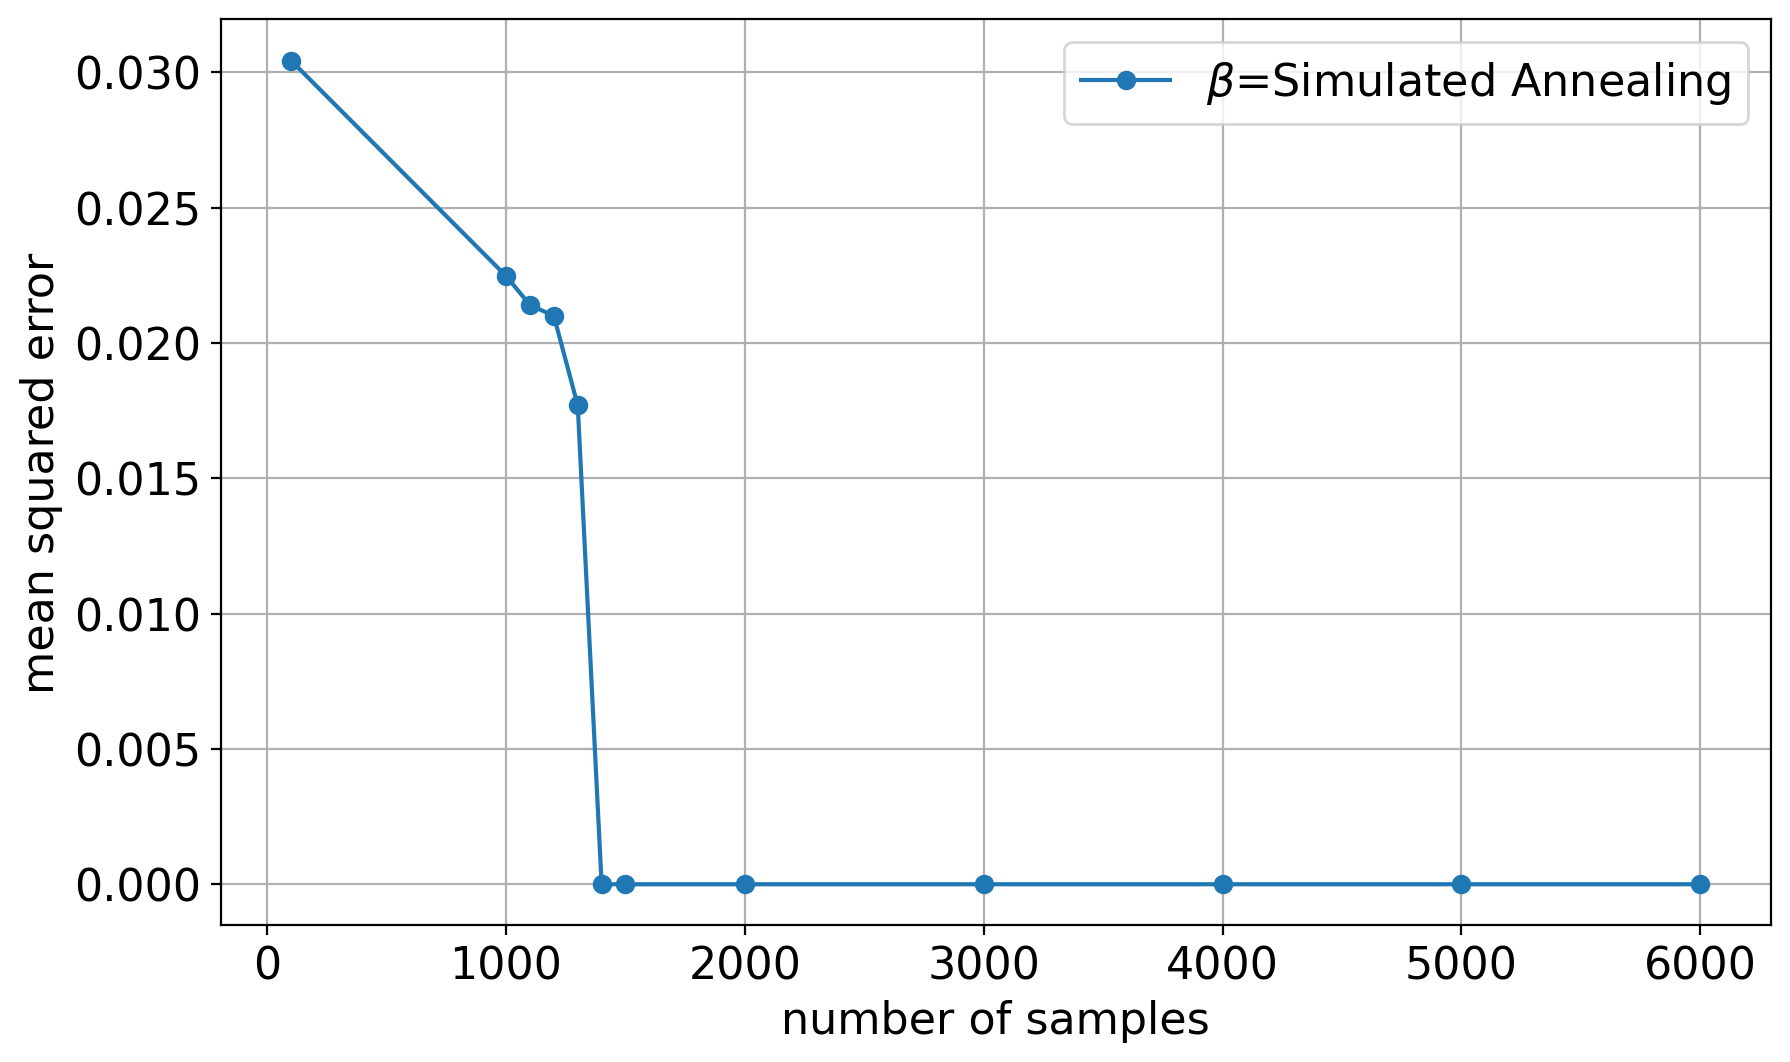

In [519]:
obj_func = "2-norm"
trans_func = "1_bit_random_flip"
init_func = "no_sparse_constraint"
beta_func = "simulated_annealing"
coef = 2/dim

all_errors_wrt_beta = {}
all_errors, all_vals= [], []
for m in num_samples:
    error, vals = 0, np.zeros((num_iters,))
    for s in seeds:
        print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
        x, y, theta_gt = gen_data(m, dim, sigma, seed=s)
        betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
        init_theta = state_init(dim, init_func)
        theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta)

        error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
        vals += np.array(val_seq)/len(seeds)

    all_errors.append(error)
    all_vals.append(vals)

all_errors_wrt_beta['Simulated Annealing'] = all_errors

# plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='d')

### Question 2
we start with the transition function that is mentioned in the project description

Running beta: 0.1, num_samples: 100, seed:0...
Running beta: 0.1, num_samples: 150, seed:0...
Running beta: 0.1, num_samples: 200, seed:0...
Running beta: 0.1, num_samples: 500, seed:0...
Running beta: 0.1, num_samples: 1000, seed:0...
Running beta: 0.1, num_samples: 2000, seed:0...
Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 150, seed:0...
Running beta: 1, num_samples: 200, seed:0...
Running beta: 1, num_samples: 500, seed:0...
Running beta: 1, num_samples: 1000, seed:0...
Running beta: 1, num_samples: 2000, seed:0...
Running beta: 5, num_samples: 100, seed:0...
Running beta: 5, num_samples: 150, seed:0...
Running beta: 5, num_samples: 200, seed:0...
Running beta: 5, num_samples: 500, seed:0...
Running beta: 5, num_samples: 1000, seed:0...
Running beta: 5, num_samples: 2000, seed:0...
Running beta: 10, num_samples: 100, seed:0...
Running beta: 10, num_samples: 150, seed:0...
Running beta: 10, num_samples: 200, seed:0...
Running beta: 10, num_samples: 500

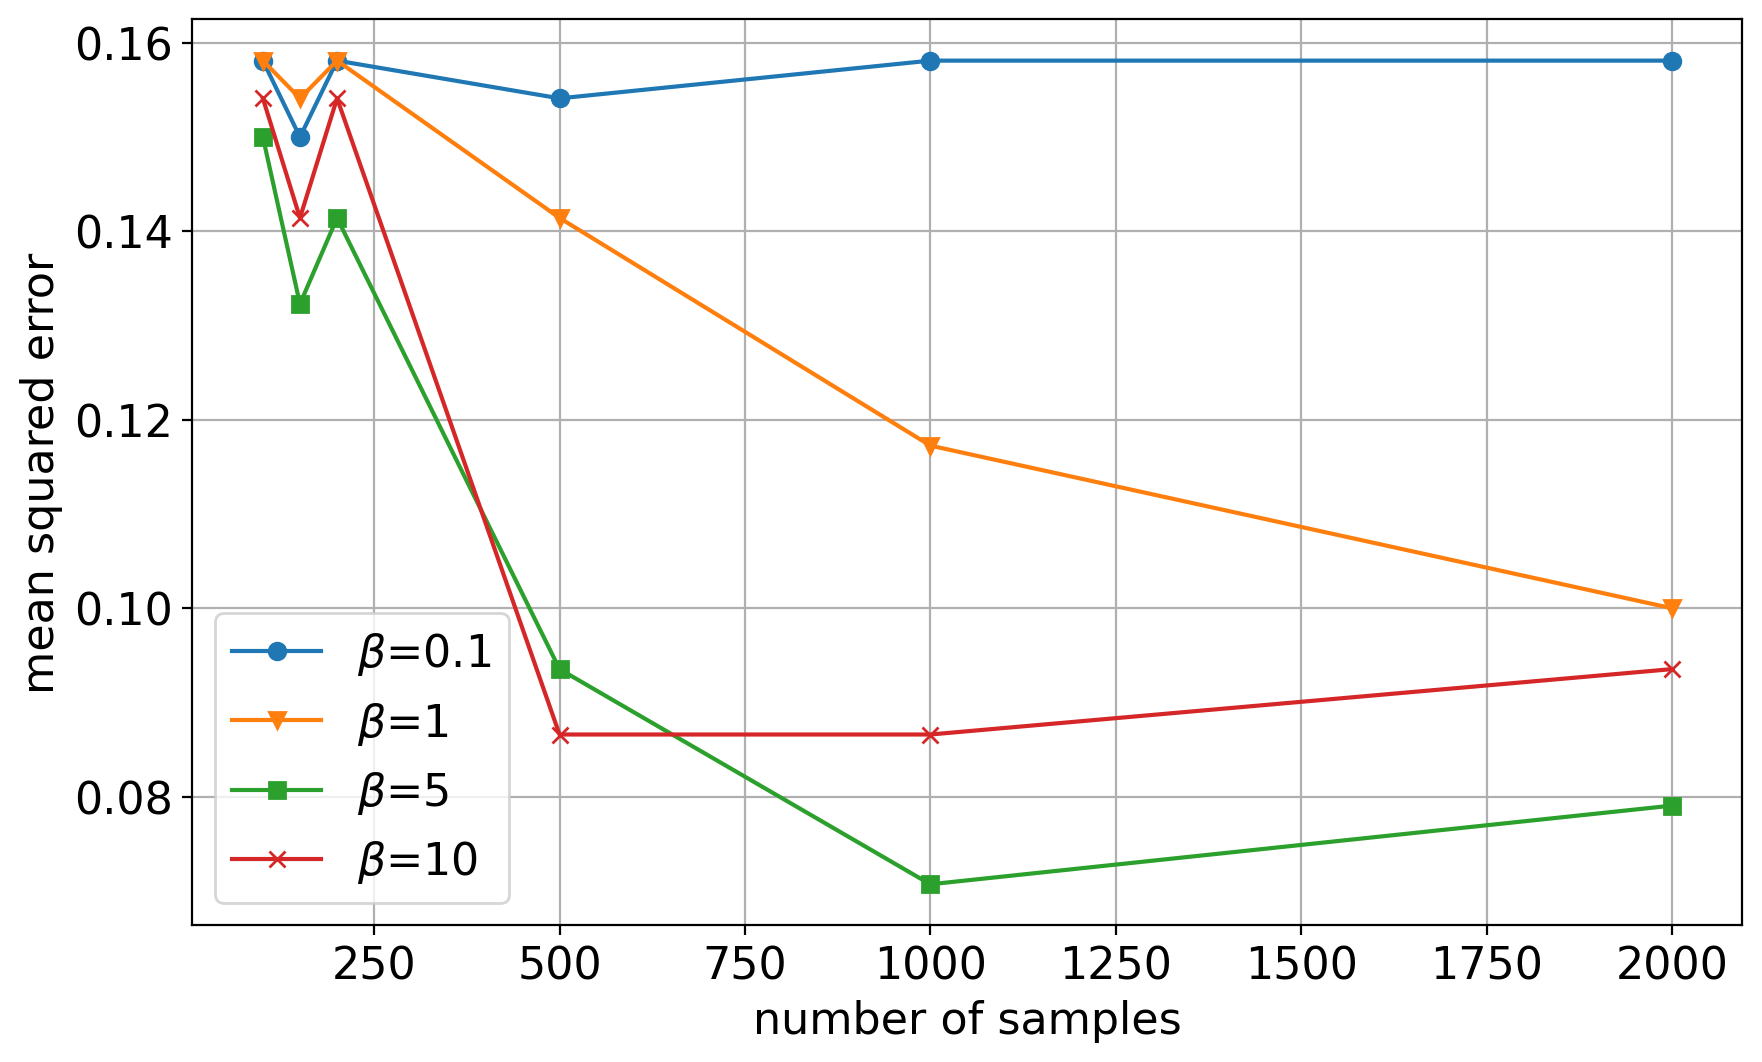

In [479]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "2_bit_random_swap_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

#### How about without self-loop?
This one removes the self-loop.

Running beta: 0.1, num_samples: 100, seed:0...
Running beta: 0.1, num_samples: 150, seed:0...
Running beta: 0.1, num_samples: 200, seed:0...
Running beta: 0.1, num_samples: 500, seed:0...
Running beta: 0.1, num_samples: 1000, seed:0...
Running beta: 0.1, num_samples: 2000, seed:0...
Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 150, seed:0...
Running beta: 1, num_samples: 200, seed:0...
Running beta: 1, num_samples: 500, seed:0...
Running beta: 1, num_samples: 1000, seed:0...
Running beta: 1, num_samples: 2000, seed:0...
Running beta: 5, num_samples: 100, seed:0...
Running beta: 5, num_samples: 150, seed:0...
Running beta: 5, num_samples: 200, seed:0...
Running beta: 5, num_samples: 500, seed:0...
Running beta: 5, num_samples: 1000, seed:0...
Running beta: 5, num_samples: 2000, seed:0...
Running beta: 10, num_samples: 100, seed:0...
Running beta: 10, num_samples: 150, seed:0...
Running beta: 10, num_samples: 200, seed:0...
Running beta: 10, num_samples: 500

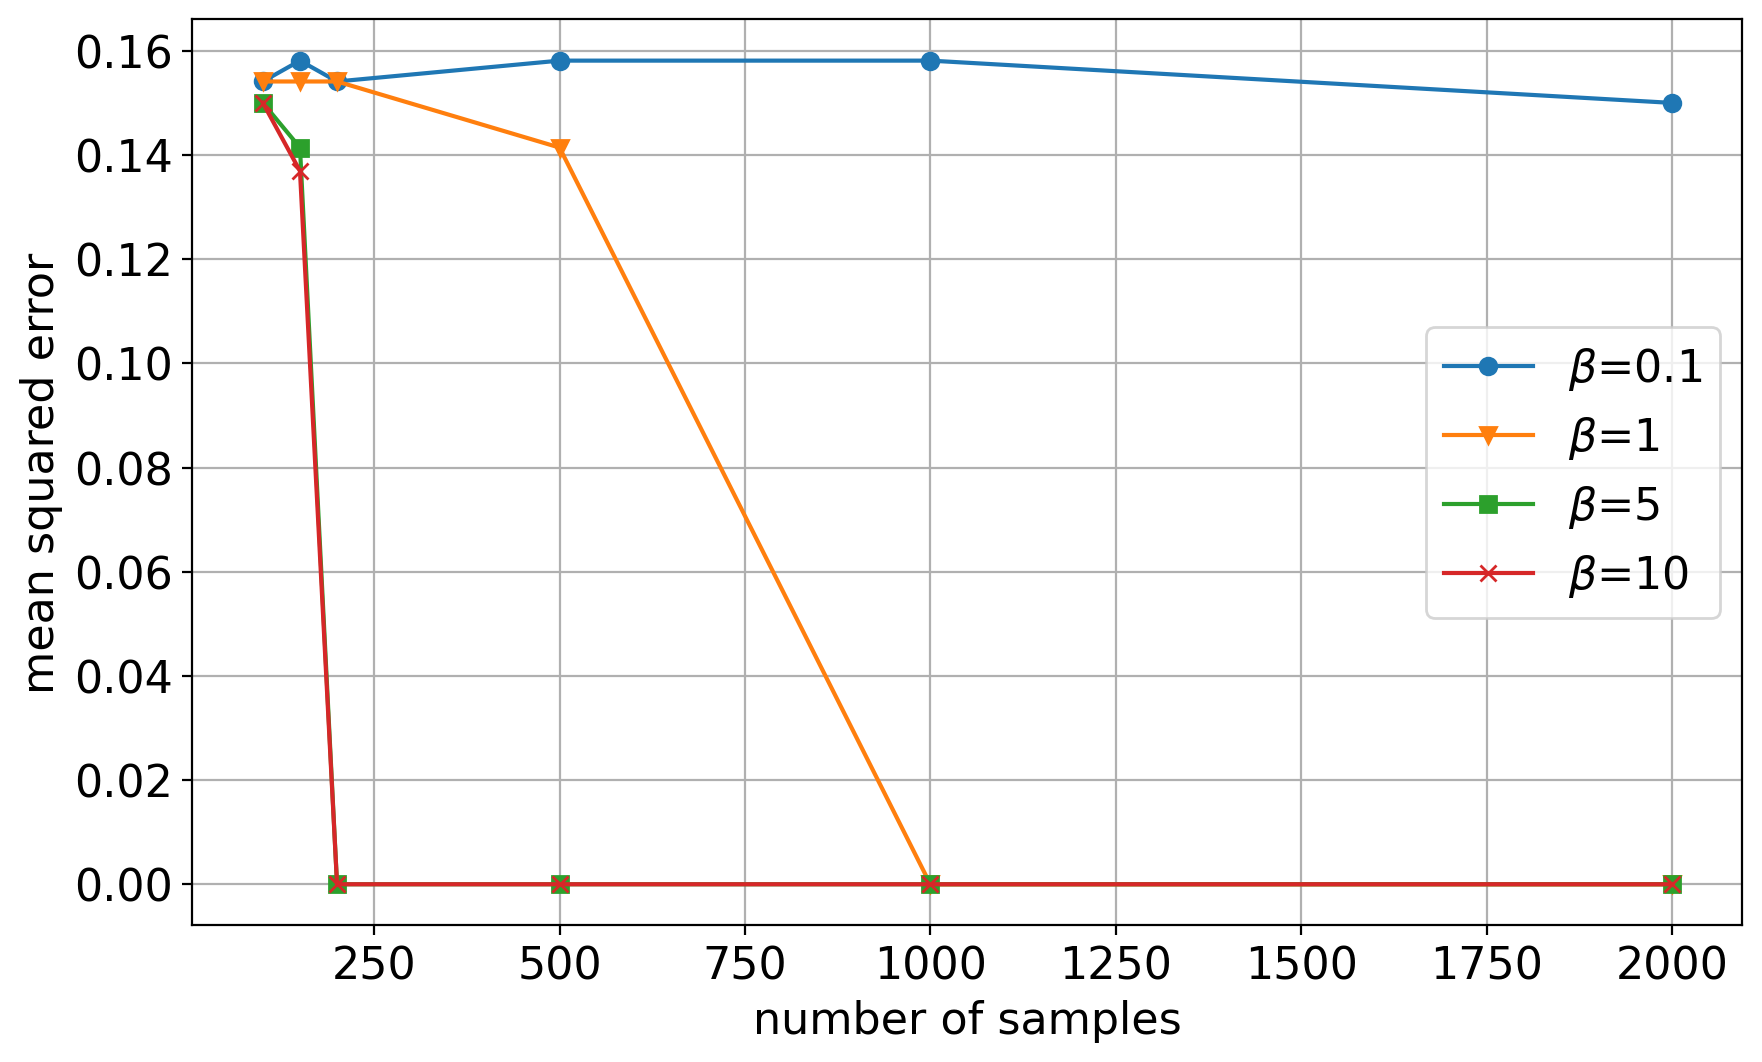

In [478]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

Running beta: 0.1, num_samples: 100, seed:0...
Running beta: 0.1, num_samples: 150, seed:0...
Running beta: 0.1, num_samples: 200, seed:0...
Running beta: 0.1, num_samples: 500, seed:0...
Running beta: 0.1, num_samples: 1000, seed:0...
Running beta: 0.1, num_samples: 2000, seed:0...
Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 150, seed:0...
Running beta: 1, num_samples: 200, seed:0...
Running beta: 1, num_samples: 500, seed:0...
Running beta: 1, num_samples: 1000, seed:0...
Running beta: 1, num_samples: 2000, seed:0...
Running beta: 5, num_samples: 100, seed:0...
Running beta: 5, num_samples: 150, seed:0...
Running beta: 5, num_samples: 200, seed:0...
Running beta: 5, num_samples: 500, seed:0...
Running beta: 5, num_samples: 1000, seed:0...
Running beta: 5, num_samples: 2000, seed:0...
Running beta: 10, num_samples: 100, seed:0...
Running beta: 10, num_samples: 150, seed:0...
Running beta: 10, num_samples: 200, seed:0...
Running beta: 10, num_samples: 500

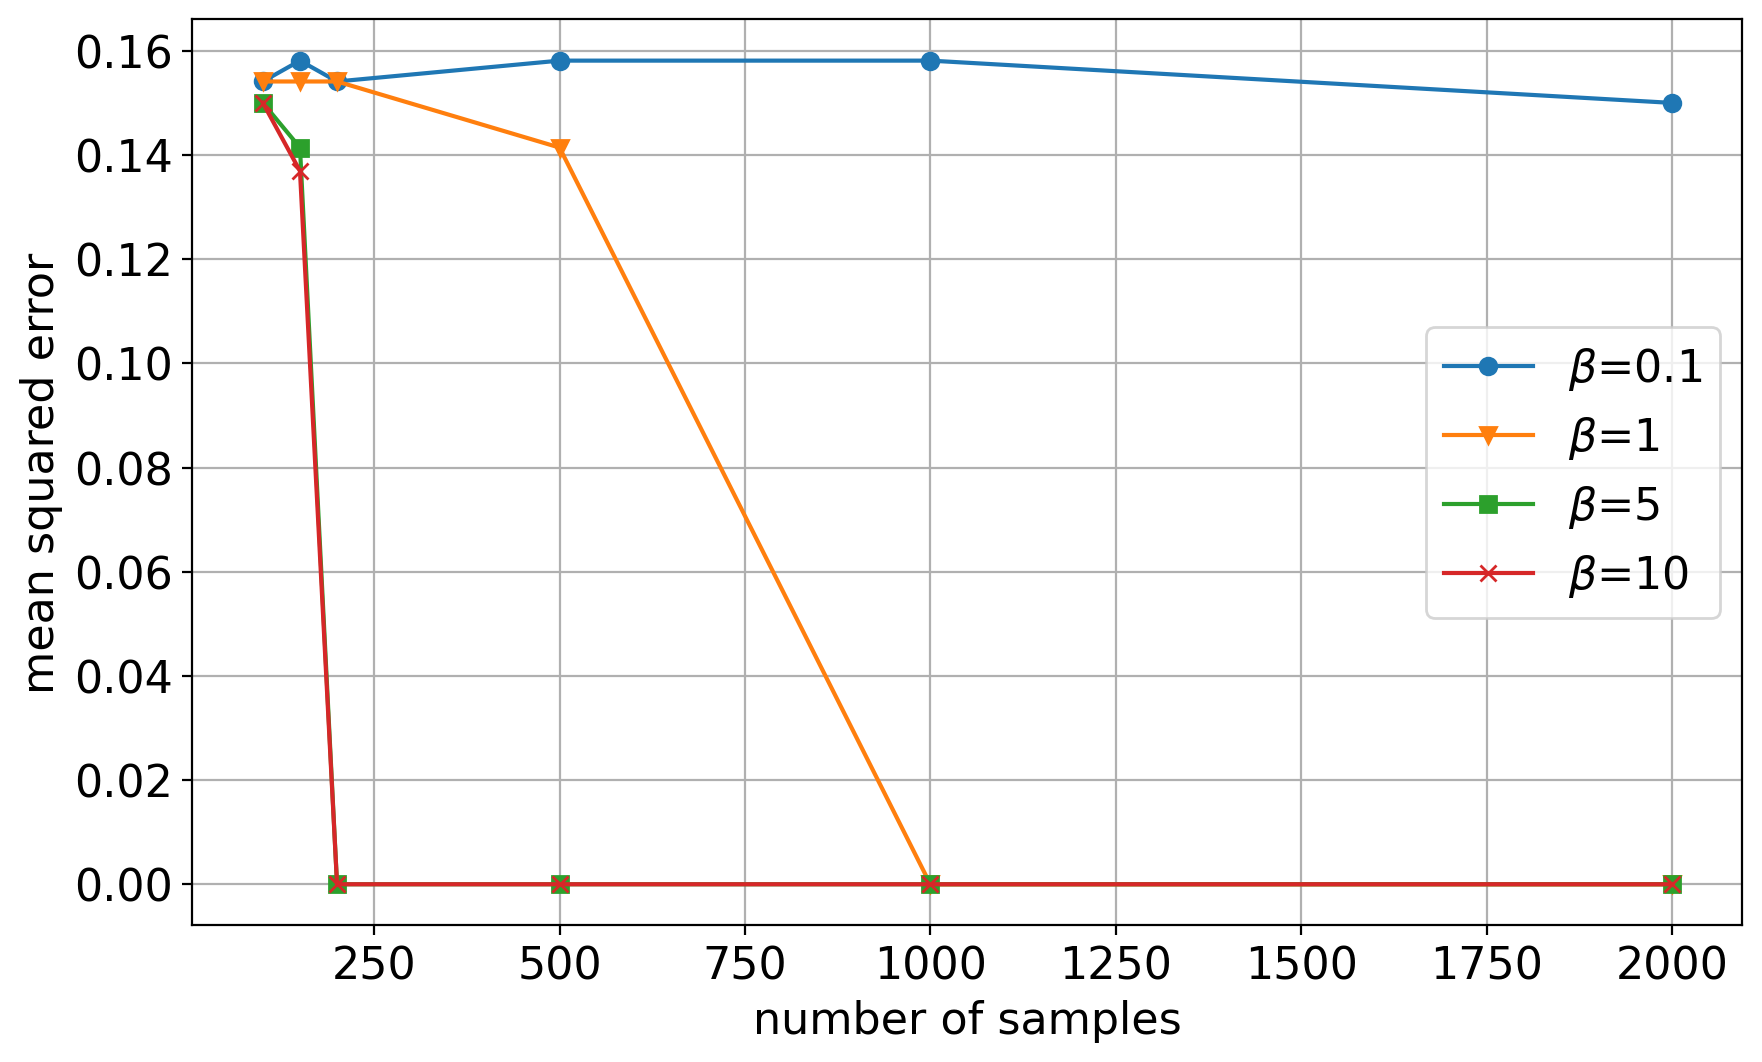

In [480]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

In [ ]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "multi_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

#### How about random walk in a clique?
There is self-loop (since it's a random walk), but the transition prob is not too high.

In [ ]:
# compared to question 1, we change transition function, initialization function and the coefficient
obj_func = "2-norm"
trans_func = "random_walk_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

### Question 3

Running beta: 0.1, num_samples: 100, seed:0...
Running beta: 0.1, num_samples: 100, seed:1...
Running beta: 0.1, num_samples: 100, seed:2...
Running beta: 0.1, num_samples: 150, seed:0...
Running beta: 0.1, num_samples: 150, seed:1...
Running beta: 0.1, num_samples: 150, seed:2...
Running beta: 0.1, num_samples: 200, seed:0...
Running beta: 0.1, num_samples: 200, seed:1...
Running beta: 0.1, num_samples: 200, seed:2...
Running beta: 0.1, num_samples: 500, seed:0...
Running beta: 0.1, num_samples: 500, seed:1...
Running beta: 0.1, num_samples: 500, seed:2...
Running beta: 0.1, num_samples: 1000, seed:0...
Running beta: 0.1, num_samples: 1000, seed:1...
Running beta: 0.1, num_samples: 1000, seed:2...
Running beta: 0.1, num_samples: 2000, seed:0...
Running beta: 0.1, num_samples: 2000, seed:1...
Running beta: 0.1, num_samples: 2000, seed:2...
Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 100, seed:1...
Running beta: 1, num_samples: 100, seed:2...
Running beta:

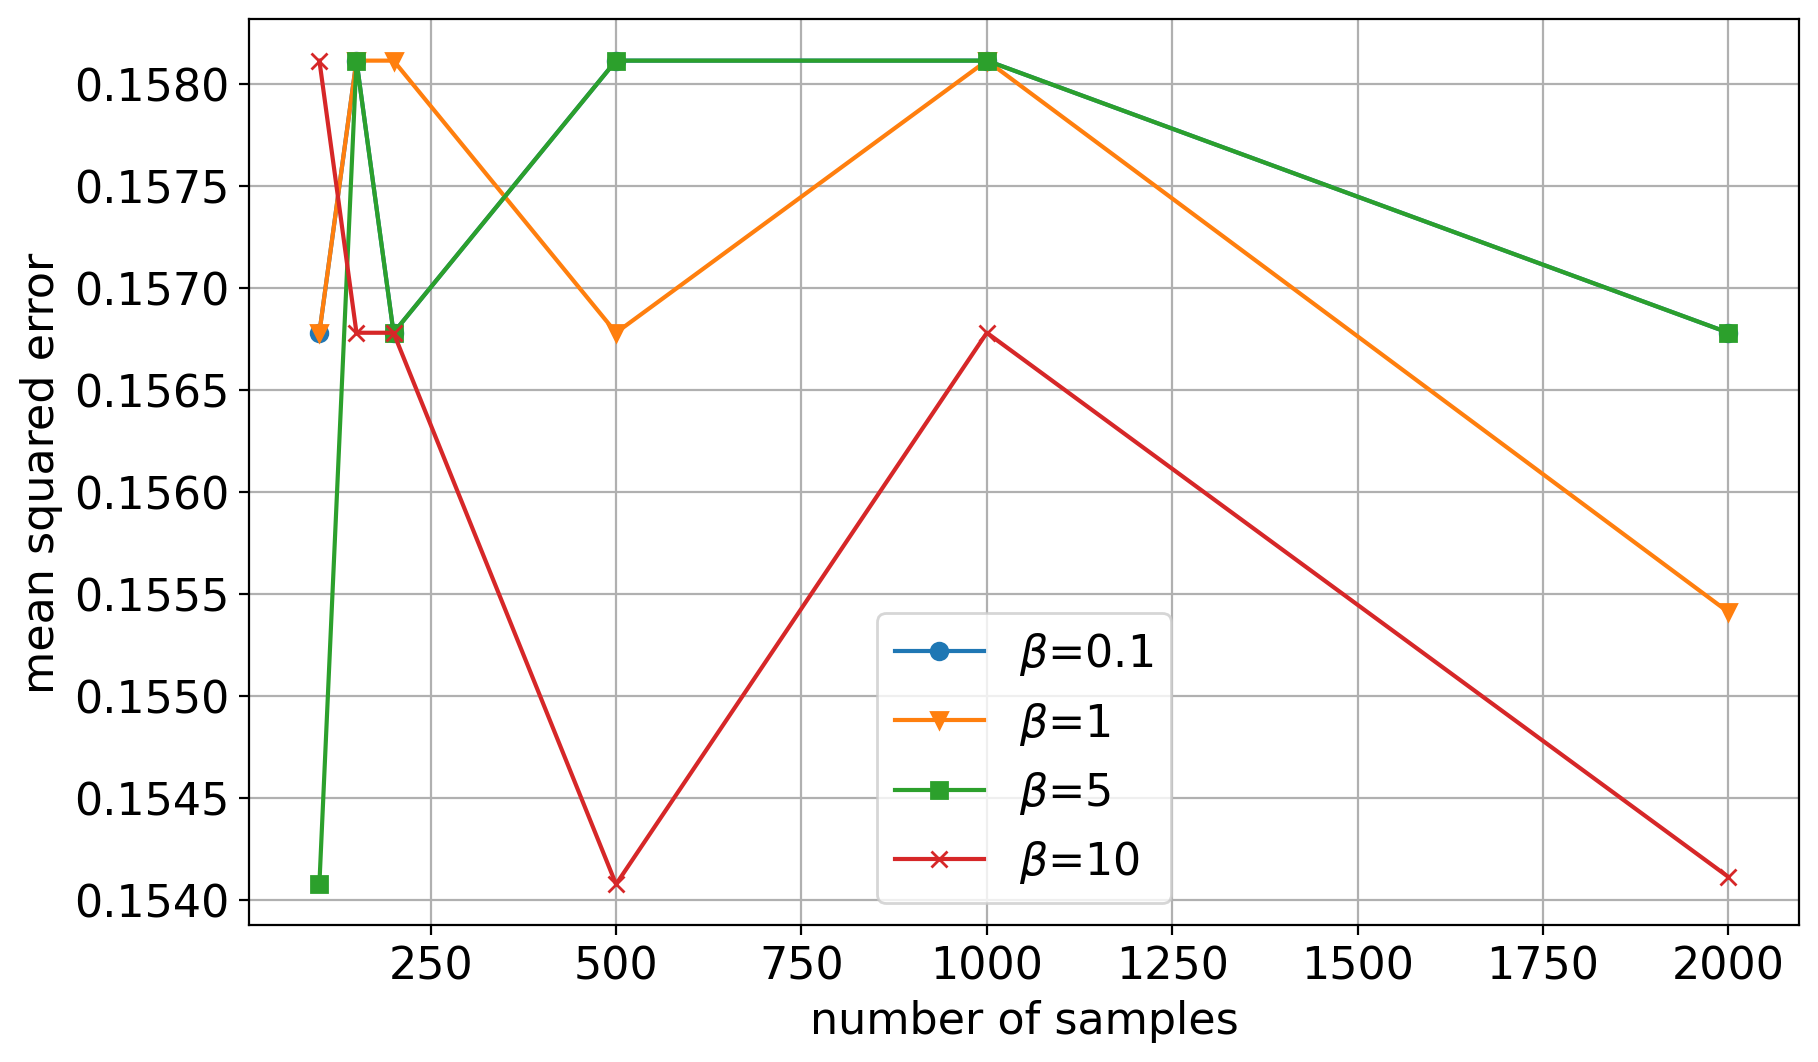

In [495]:
# compared to question 2, we change objective function (TODO)
obj_func = "logistic_exponential"  # logistic_exponential, zero_one_loss, hinge_loss, bce_loss
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

Running beta: 0.1, num_samples: 100, seed:0...
Running beta: 0.1, num_samples: 100, seed:1...
Running beta: 0.1, num_samples: 100, seed:2...
Running beta: 0.1, num_samples: 150, seed:0...
Running beta: 0.1, num_samples: 150, seed:1...
Running beta: 0.1, num_samples: 150, seed:2...
Running beta: 0.1, num_samples: 200, seed:0...
Running beta: 0.1, num_samples: 200, seed:1...
Running beta: 0.1, num_samples: 200, seed:2...
Running beta: 0.1, num_samples: 500, seed:0...
Running beta: 0.1, num_samples: 500, seed:1...
Running beta: 0.1, num_samples: 500, seed:2...
Running beta: 0.1, num_samples: 1000, seed:0...
Running beta: 0.1, num_samples: 1000, seed:1...
Running beta: 0.1, num_samples: 1000, seed:2...
Running beta: 0.1, num_samples: 2000, seed:0...
Running beta: 0.1, num_samples: 2000, seed:1...
Running beta: 0.1, num_samples: 2000, seed:2...
Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 100, seed:1...
Running beta: 1, num_samples: 100, seed:2...
Running beta:

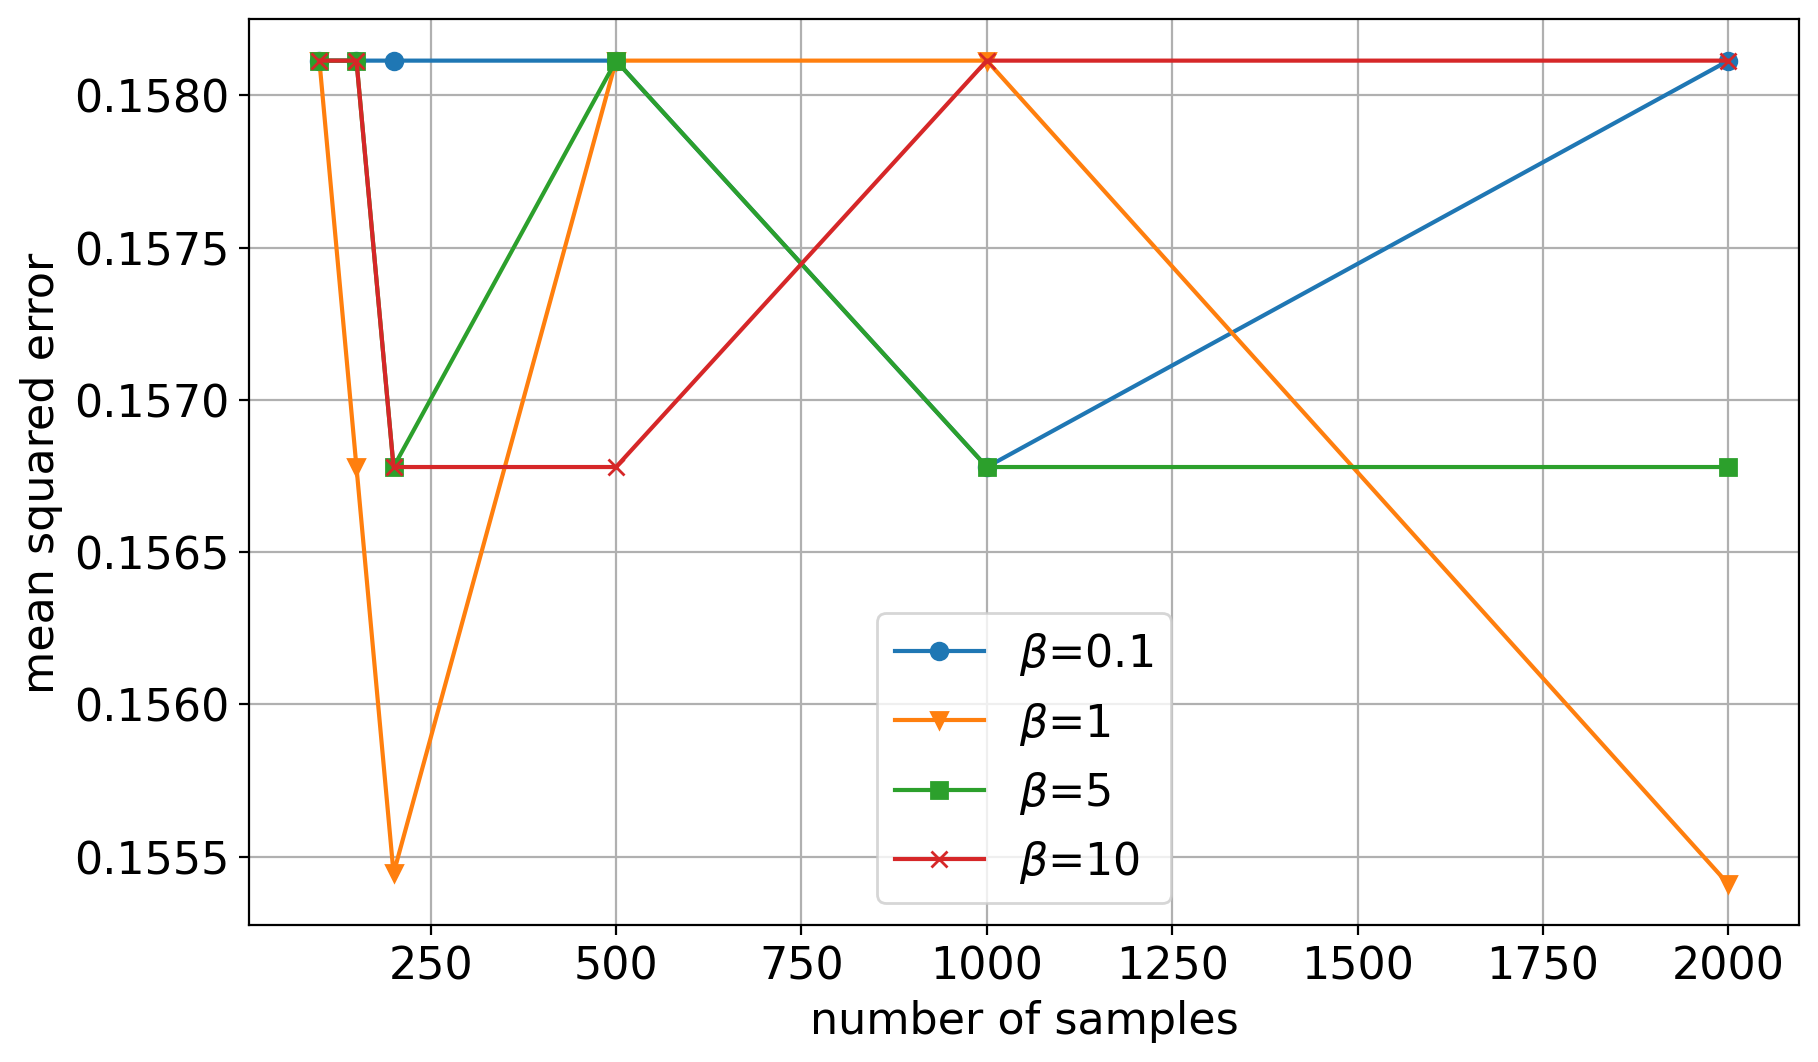

In [496]:
# compared to question 2, we change objective function (TODO)
obj_func = "zero_one_loss"  # logistic_exponential, zero_one_loss, hinge_loss, bce_loss
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 150, seed:0...
Running beta: 1, num_samples: 200, seed:0...
Running beta: 1, num_samples: 500, seed:0...
Running beta: 1, num_samples: 750, seed:0...
Running beta: 1, num_samples: 1000, seed:0...
Running beta: 1, num_samples: 2000, seed:0...
Running beta: 5, num_samples: 100, seed:0...
Running beta: 5, num_samples: 150, seed:0...
Running beta: 5, num_samples: 200, seed:0...
Running beta: 5, num_samples: 500, seed:0...
Running beta: 5, num_samples: 750, seed:0...
Running beta: 5, num_samples: 1000, seed:0...
Running beta: 5, num_samples: 2000, seed:0...
Running beta: 10, num_samples: 100, seed:0...
Running beta: 10, num_samples: 150, seed:0...
Running beta: 10, num_samples: 200, seed:0...
Running beta: 10, num_samples: 500, seed:0...
Running beta: 10, num_samples: 750, seed:0...
Running beta: 10, num_samples: 1000, seed:0...
Running beta: 10, num_samples: 2000, seed:0...
Running beta: 15, num_samples: 100, seed:0

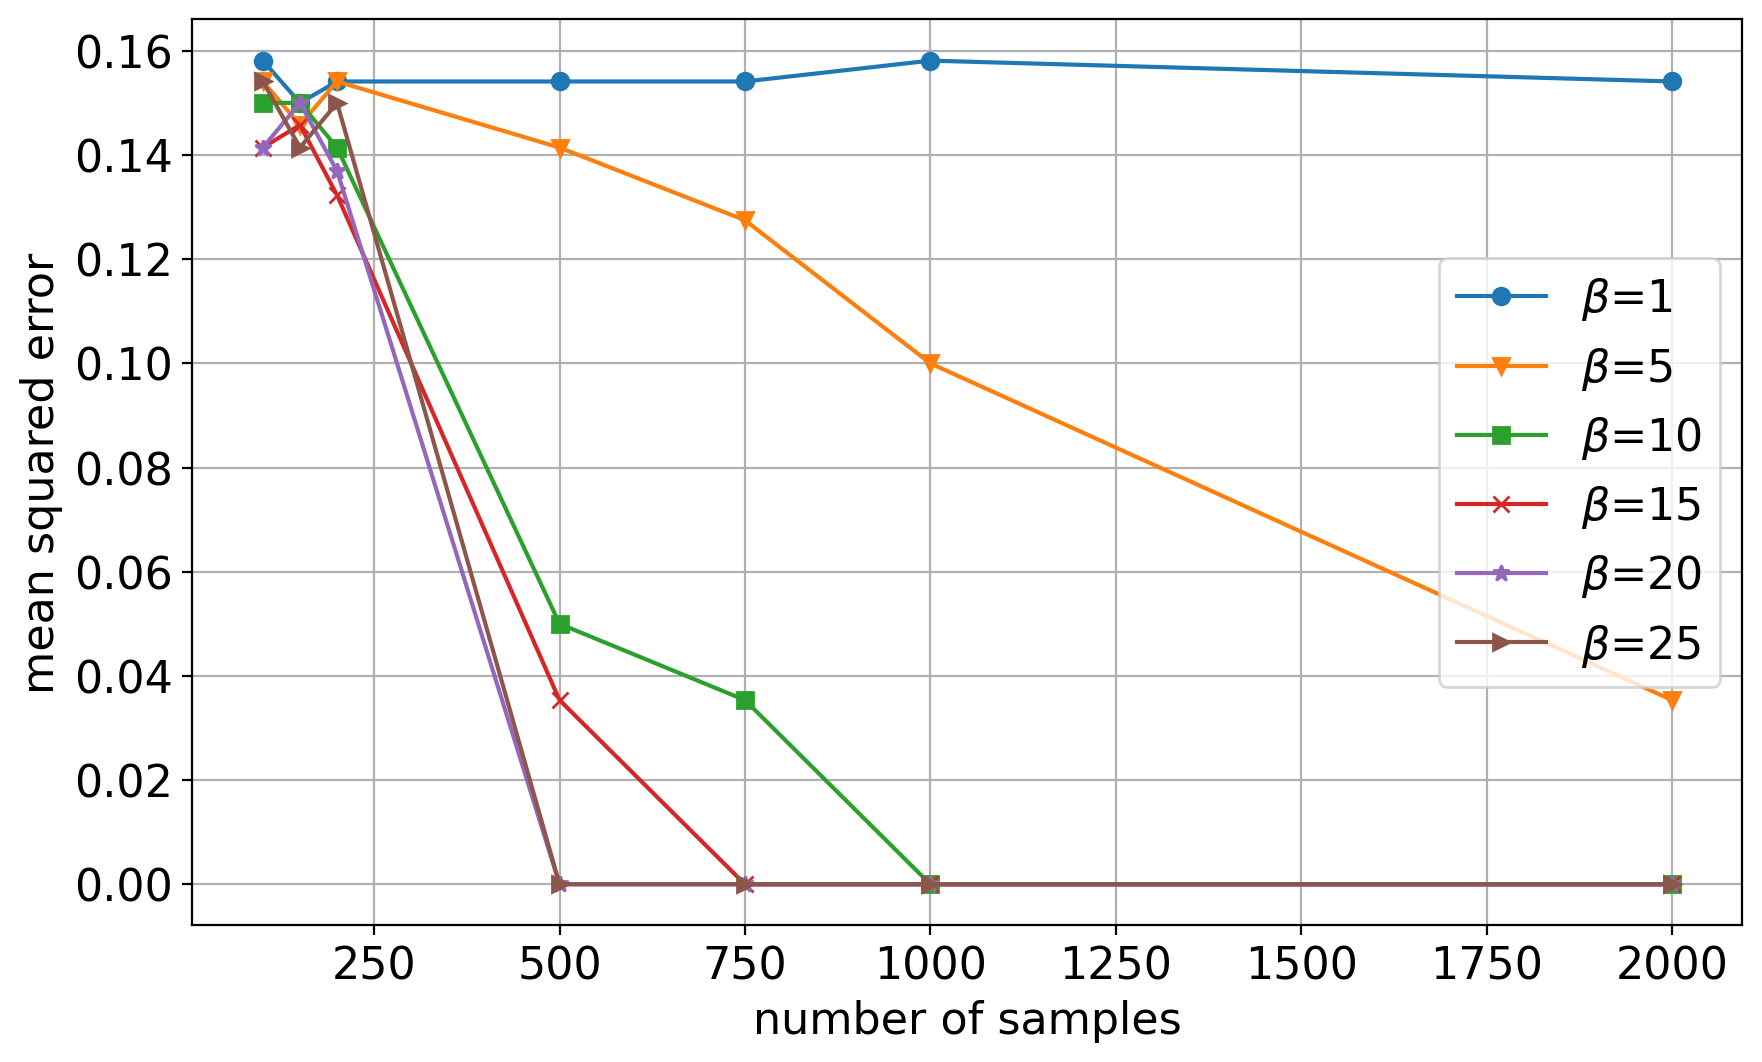

In [529]:
# compared to question 2, we change objective function (TODO)
obj_func = "2-norm-sign"  # logistic_exponential, zero_one_loss, hinge_loss, bce_loss
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

# seeds = range(1)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

In [520]:
# compared to question 2, we change objective function (TODO)
obj_func = "hinge_loss"  # logistic_exponential, zero_one_loss, hinge_loss, bce_loss
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')

Running beta: 1, num_samples: 100, seed:0...
Running beta: 1, num_samples: 1000, seed:0...
Running beta: 1, num_samples: 1100, seed:0...
Running beta: 1, num_samples: 1200, seed:0...
Running beta: 1, num_samples: 1300, seed:0...
Running beta: 1, num_samples: 1400, seed:0...
Running beta: 1, num_samples: 1500, seed:0...
Running beta: 1, num_samples: 2000, seed:0...
Running beta: 1, num_samples: 3000, seed:0...
Running beta: 1, num_samples: 4000, seed:0...
Running beta: 1, num_samples: 5000, seed:0...
Running beta: 1, num_samples: 6000, seed:0...
Running beta: 2, num_samples: 100, seed:0...
Running beta: 2, num_samples: 1000, seed:0...
Running beta: 2, num_samples: 1100, seed:0...
Running beta: 2, num_samples: 1200, seed:0...
Running beta: 2, num_samples: 1300, seed:0...
Running beta: 2, num_samples: 1400, seed:0...
Running beta: 2, num_samples: 1500, seed:0...
Running beta: 2, num_samples: 2000, seed:0...
Running beta: 2, num_samples: 3000, seed:0...
Running beta: 2, num_samples: 4000, 

KeyboardInterrupt: 

Running beta: 1, num_samples: 100, seed:0...


/var/folders/b5/xtzqf23x5r95jympl5yfm7ym0000gn/T/ipykernel_21042/1865735564.py:126: RuntimeWarning: invalid value encountered in log
  return - (y * np.log(pred + delta) + (1 - y) * np.log(1 - pred + delta)).mean()


Running beta: 1, num_samples: 150, seed:0...
Running beta: 1, num_samples: 200, seed:0...
Running beta: 1, num_samples: 500, seed:0...
Running beta: 1, num_samples: 750, seed:0...
Running beta: 1, num_samples: 1000, seed:0...
Running beta: 1, num_samples: 2000, seed:0...
Running beta: 5, num_samples: 100, seed:0...
Running beta: 5, num_samples: 150, seed:0...
Running beta: 5, num_samples: 200, seed:0...
Running beta: 5, num_samples: 500, seed:0...
Running beta: 5, num_samples: 750, seed:0...
Running beta: 5, num_samples: 1000, seed:0...
Running beta: 5, num_samples: 2000, seed:0...
Running beta: 10, num_samples: 100, seed:0...
Running beta: 10, num_samples: 150, seed:0...
Running beta: 10, num_samples: 200, seed:0...
Running beta: 10, num_samples: 500, seed:0...
Running beta: 10, num_samples: 750, seed:0...
Running beta: 10, num_samples: 1000, seed:0...
Running beta: 10, num_samples: 2000, seed:0...
Running beta: 15, num_samples: 100, seed:0...
Running beta: 15, num_samples: 150, seed:

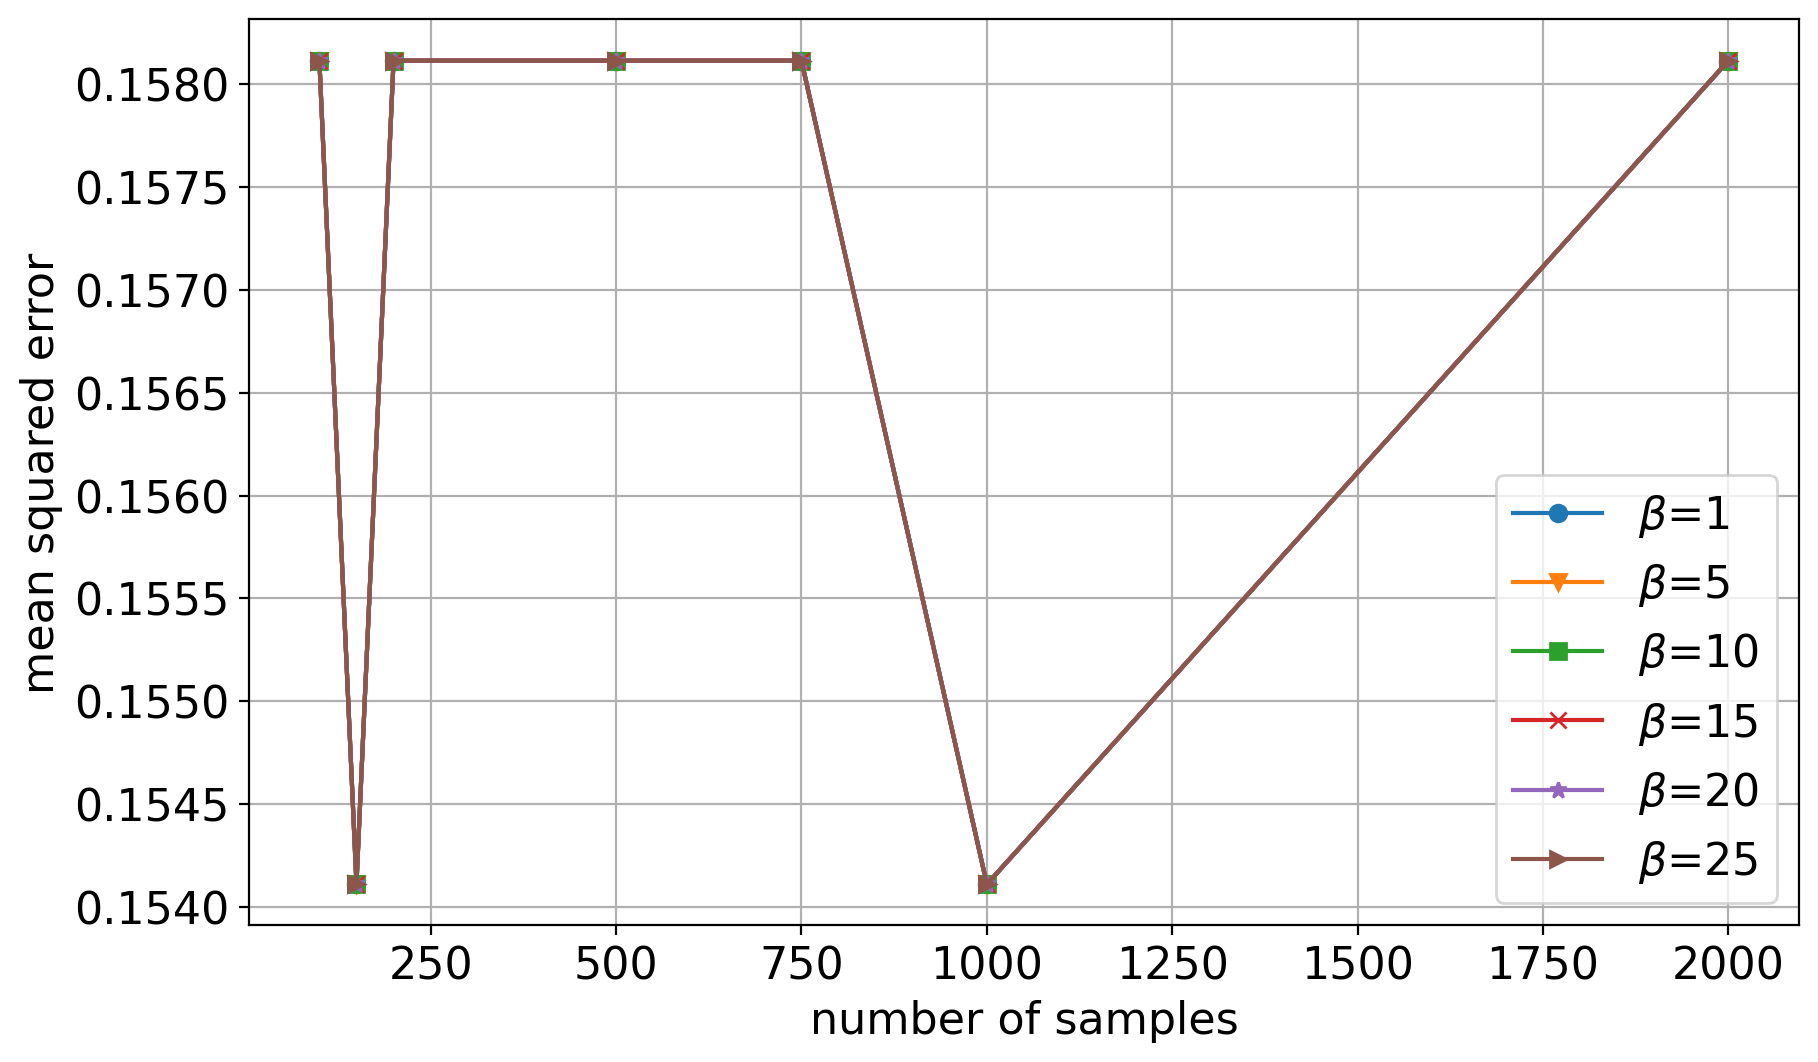

In [530]:
# compared to question 2, we change objective function (TODO)
obj_func = "bce_loss"  # logistic_exponential, zero_one_loss, hinge_loss, bce_loss
trans_func = "2_bit_random_flip_for_sparsity"
init_func = "sparse_constraint"
beta_func = "constant"
sparsity = int(dim/100) # only used for question 2 & 3
coef = 1/(2 * sparsity)

all_errors_wrt_beta = {}
for b in beta_list:
    all_errors, all_vals= [], []
    for m in num_samples:
        error, vals = 0, np.zeros((num_iters,))
        for s in seeds:
            print(f"Running beta: {b}, num_samples: {m}, seed:{s}...")
            x, y, theta_gt = gen_data(m, dim, sigma, seed=s, func=init_func, sparsity=sparsity)
            betas = gen_beta_seq(x, y, obj, eps, dim, num_iters, beta_func, constant=b)
            init_theta = state_init(dim, sparsity=sparsity, func=init_func)
            theta_seq, val_seq = run_MH(x, y, num_iters, betas, trans_func, obj_func, init_theta, sparsity=sparsity)

            error += eval(theta_gt, theta_seq, coef, warmup_iters=-1)/len(seeds) # estimate mean squared error, averaged over theta and X
            vals += np.array(val_seq)/len(seeds)

        all_errors.append(error)
        all_vals.append(vals)

    all_errors_wrt_beta[b] = all_errors

    # plot_error(num_samples, all_errors)

plot_error_wrt_beta(num_samples, all_errors_wrt_beta, beta_list, coef='s')